In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings


# Load the dataset
file_path = 'data.csv'
df = pd.read_csv(file_path, delimiter=';')

# Define target and feature sets
target_column = 'Target'

# Define all features by type
categorical_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Previous qualification', 'Nacionality', 'Mother\'s qualification',
    'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation'
]
binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]
numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Selected features after Random Forest
selected_features = {
    'categorical': ['Course', 'Application mode'],
    'binary': ['Tuition fees up to date', 'Debtor', 'Scholarship holder'],
    'numerical': [
        'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (evaluations)',
        'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (enrolled)',
        'Admission grade', 'Curricular units 1st sem (credited)',
        'Previous qualification (grade)', 'Curricular units 1st sem (grade)'
    ]
}

# Extract full and selected feature lists
full_feature_set = categorical_features + binary_features + numerical_features
selected_feature_set = (
    selected_features['categorical'] +
    selected_features['binary'] +
    selected_features['numerical']
)

# Create a version of the dataframe with whitespace-trimmed column names
df.columns = df.columns.str.strip()

# Encode target as categorical (e.g., integer)
df[target_column] = df[target_column].astype('category').cat.codes

# Prepare to split for CV and feature sets
X_full = df[full_feature_set]
X_selected = df[selected_feature_set]
y = df[target_column]

# Set up 10-fold stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Display confirmation
{
    "X_full_shape": X_full.shape,
    "X_selected_shape": X_selected.shape,
    "y_class_distribution": y.value_counts().to_dict(),
    "num_folds": 10
}


{'X_full_shape': (4424, 36),
 'X_selected_shape': (4424, 15),
 'y_class_distribution': {2: 2209, 0: 1421, 1: 794},
 'num_folds': 10}

In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore', over='ignore')

# === LOAD & PREPARE DATA ===
def load_data(filepath='data.csv'):
    df = pd.read_csv(filepath, delimiter=';')
    df.columns = df.columns.str.strip()
    target_column = 'Target: String'  # Make sure this matches your actual column name
    # Check if target column exists
    if target_column not in df.columns:
        target_column = 'Target'  # Try alternative name
    
    df[target_column] = df[target_column].astype('category').cat.codes
    y = df[target_column]
    return df, y

# === DEFINE FEATURE SETS ===
categorical_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Previous qualification', 'Nacionality', 'Mother\'s qualification',
    'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation'
]
binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]
numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]
selected_features = {
    'categorical': ['Course', 'Application mode'],
    'binary': ['Tuition fees up to date', 'Debtor', 'Scholarship holder'],
    'numerical': [
        'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (evaluations)',
        'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (enrolled)',
        'Admission grade', 'Curricular units 1st sem (credited)',
        'Previous qualification (grade)', 'Curricular units 1st sem (grade)'
    ]
}

# === FAIRNESS METRICS ===
def compute_statistical_parity(y_pred, sensitive_attr, positive_class):
    """Calculate difference in selection rates between groups."""
    group_0 = sensitive_attr == 0  # Female
    group_1 = sensitive_attr == 1  # Male
    if np.sum(group_0) == 0 or np.sum(group_1) == 0:
        return np.nan
    return np.mean(y_pred[group_0] == positive_class) - np.mean(y_pred[group_1] == positive_class)

def compute_equalized_opportunity(y_true, y_pred, sensitive_attr, positive_class):
    """Calculate difference in true positive rates between groups."""
    mask_0 = (sensitive_attr == 0) & (y_true == positive_class)  # Female + actual dropouts
    mask_1 = (sensitive_attr == 1) & (y_true == positive_class)  # Male + actual dropouts
    if np.sum(mask_0) == 0 or np.sum(mask_1) == 0:
        return np.nan
    tpr_0 = np.mean(y_pred[mask_0] == positive_class)
    tpr_1 = np.mean(y_pred[mask_1] == positive_class)
    return tpr_0 - tpr_1

# === ADVERSARIAL EXAMPLE GENERATOR (SAFER IMPLEMENTATION) ===
def generate_adversarial_examples(X, y, model, epsilon=0.01):
    """Generate adversarial examples with error handling."""
    try:
        X = X.astype(np.float32)
        if hasattr(X, "toarray"):  # if sparse, convert to dense
            X = X.toarray()
        
        # Simple fitting for different model types
        if isinstance(model, MLPClassifier):
            # For sklearn models, use fit directly
            # Temporarily store early_stopping value
            early_stopping = getattr(model, 'early_stopping', False)
            if early_stopping:
                model.set_params(early_stopping=False)
            
            model.fit(X, y)
            
            # Restore original early_stopping value
            if early_stopping:
                model.set_params(early_stopping=early_stopping)
                
        elif hasattr(model, 'fit') and not hasattr(model, 'predict_proba'):
            # If model can fit but doesn't predict probas
            model.fit(X, y)
            # Can't create adversarial examples, return original
            return X
            
        # First ensure model can predict probabilities
        if hasattr(model, 'predict_proba'):
            try:
                probs = model.predict_proba(X)
            except Exception as e:
                print(f"Error in predict_proba: {e}")
                return X  # Return original if predict_proba fails
                
            grads = np.zeros_like(X)
            
            # Calculate simple gradient approximation for each feature
            for i in range(X.shape[1]):
                X_perturbed = X.copy()
                X_perturbed[:, i] += epsilon
                
                # Get new probabilities
                try:
                    new_probs = model.predict_proba(X_perturbed)
                except Exception as e:
                    print(f"Error in calculating perturbed probabilities: {e}")
                    continue  # Skip this feature
                
                # Calculate loss difference - ensuring dimensions match
                try:
                    # Create one-hot encoding of labels
                    one_hot_y = np.zeros_like(probs)
                    for j, cls in enumerate(y):
                        if cls < one_hot_y.shape[1]:  # Safety check
                            one_hot_y[j, cls] = 1
                    
                    # Calculate loss difference
                    loss_diff = np.sum((new_probs - probs) * (one_hot_y - probs), axis=1)
                    grads[:, i] = loss_diff
                except Exception as e:
                    print(f"Error in gradient calculation: {e}")
                    continue  # Skip this feature
            
            # Create adversarial examples
            if np.any(grads):  # Only perturb if we have gradients
                perturbed_X = np.clip(X + epsilon * np.sign(grads), X.min(), X.max())
                return perturbed_X
            else:
                return X  # Return original if no gradients
        else:
            return X  # Return original if no predict_proba
    except Exception as e:
        print(f"Error in adversarial generation: {e}")
        return X  # Return original data on any error

# === MODEL FACTORY ===
# === MODEL FACTORY with Fixed MINN Implementation ===
# === MODEL FACTORY with Fixed MINN Implementation ===
# Fix for MINN model that doesn't use scikit-learn wrappers
def build_model_pipeline(model_type, categorical, numerical):
    """Create preprocessing pipeline with specified model."""
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
        ('num', StandardScaler(), numerical)
    ], remainder='drop')
    
    if model_type == "dnn":
        # Simple Dense Neural Network using sklearn's MLPClassifier
        classifier = MLPClassifier(
            hidden_layer_sizes=(64,),
            max_iter=1000,
            random_state=42,
            solver='adam',
            learning_rate_init=1e-3,
            activation='tanh',
            early_stopping=False,
            tol=1e-4
        )
        
        return Pipeline([
            ('preprocessor', preprocessor),
            ('clf', classifier)
        ])
        
    elif model_type == "minn":
        # Return just the preprocessor for MINN - we'll handle the model separately
        # This avoids the scikit-learn compatibility issues
        return preprocessor
            
    elif model_type == "tabnet":
        # Using TabNet classifier if available
        try:
            from pytorch_tabnet.tab_model import TabNetClassifier
            
            classifier = TabNetClassifier(
                optimizer_params=dict(lr=2e-2),
                verbose=0
            )
        except ImportError as e:
            print(f"TabNet import error: {e}. Falling back to MLPClassifier.")
            # Fallback if TabNet is not available
            classifier = MLPClassifier(
                hidden_layer_sizes=(32,),
                max_iter=500,
                random_state=42,
                early_stopping=False
            )
            
        return Pipeline([
            ('preprocessor', preprocessor),
            ('clf', classifier)
        ])
    else:
        # Default fallback
        classifier = MLPClassifier(
            hidden_layer_sizes=(32,),
            max_iter=500,
            random_state=42,
            early_stopping=False
        )
        
        return Pipeline([
            ('preprocessor', preprocessor),
            ('clf', classifier)
        ])

  

# === EXPERIMENT WRAPPER ===
def run_full_experiment(X_full, X_selected, y, df, skf, selected_features, model_types=["dnn", "minn", "tabnet"]):
    """Run cross-validation experiment with specified models and feature sets."""
    results = defaultdict(list)
    feature_sets = {"full": X_full, "selected": X_selected}

    for model_type in model_types:
        print(f"\nRunning model: {model_type.upper()}")
        for feature_set_name, X in feature_sets.items():
            print(f"  Feature set: {feature_set_name}")
            if feature_set_name == 'full':
                categorical = [f for f in categorical_features if f in X.columns]
                numerical = [f for f in numerical_features if f in X.columns]
                binary = [f for f in binary_features if f in X.columns]
            else:
                categorical = [f for f in selected_features['categorical'] if f in X.columns]
                numerical = [f for f in selected_features['numerical'] if f in X.columns]
                binary = [f for f in selected_features['binary'] if f in X.columns]

            # Merge binary features into numerical for preprocessing
            all_numerical = numerical + binary

            for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                print(f"    Fold {fold_idx + 1}/{skf.get_n_splits()}")
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Get sensitive attribute
                gender_column = 'Gender'
                if gender_column in df.columns:
                    gender_test = df.iloc[test_idx][gender_column].values
                else:
                    # Use placeholder if gender not available
                    gender_test = np.zeros(len(test_idx))
                
                y_true = y_test.to_numpy()
                positive_class = 0  # assuming 0 = Dropout

                def evaluate_and_store(model_name, variant, y_pred):
                    """Store evaluation metrics."""
                    results["model"].append(model_name)
                    results["feature_set"].append(feature_set_name)
                    results["variant"].append(variant)
                    results["fold"].append(fold_idx)
                    
                    # Performance metrics
                    results["accuracy"].append(accuracy_score(y_test, y_pred))
                    results["precision"].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
                    results["recall"].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
                    results["f1"].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
                    
                    # Fairness metrics
                    results["SPD"].append(compute_statistical_parity(y_pred, gender_test, positive_class))
                    results["EO"].append(compute_equalized_opportunity(y_true, y_pred, gender_test, positive_class))

                try:
                    # Special handling for MINN model
                    if model_type == "minn":
                        # Use a direct MINN implementation without scikit-learn wrappers
                        try:
                            import numpy as np
                            
                            # Get the preprocessor for transforming the data
                            preprocessor = build_model_pipeline(model_type, categorical, all_numerical)
                            
                            # Transform the data
                            X_train_enc = preprocessor.fit_transform(X_train)
                            X_test_enc = preprocessor.transform(X_test)
                            
                            # Make sure data is in the right format
                            if hasattr(X_train_enc, "toarray"):
                                X_train_enc = X_train_enc.toarray()
                            if hasattr(X_test_enc, "toarray"):
                                X_test_enc = X_test_enc.toarray()
                            
                            # Convert to proper numpy arrays
                            X_train_enc = np.asarray(X_train_enc).astype(np.float32)
                            X_test_enc = np.asarray(X_test_enc).astype(np.float32)
                            y_train_np = np.asarray(y_train).astype(np.int32)
                            
                            # ===== Direct TensorFlow implementation for MINN (Baseline) =====
                            print(f"      Training baseline MINN model (direct implementation)")
                            # Import TensorFlow directly
                            try:
                                import tensorflow as tf
                                from tensorflow.keras.models import Model
                                from tensorflow.keras.layers import Input, Dense, Dropout
                                
                                # Build the MINN model directly
                                input_dim = X_train_enc.shape[1]
                                num_classes = len(np.unique(y_train))
                                
                                # Create model
                                inputs = Input(shape=(input_dim,))
                                x = Dense(64, activation='relu')(inputs)
                                x = Dropout(0.2)(x)
                                x = Dense(32, activation='relu')(x)
                                outputs = Dense(num_classes, activation='softmax')(x)
                                
                                model = Model(inputs=inputs, outputs=outputs)
                                model.compile(
                                    loss='sparse_categorical_crossentropy',
                                    optimizer='adam',
                                    metrics=['accuracy']
                                )
                                
                                # Fit the model
                                model.fit(
                                    X_train_enc, y_train_np,
                                    epochs=50,
                                    batch_size=32,
                                    verbose=0
                                )
                                
                                # Predict
                                y_pred_proba = model.predict(X_test_enc)
                                y_pred = np.argmax(y_pred_proba, axis=1)
                                
                                # Evaluate
                                evaluate_and_store(model_type, "baseline", y_pred)
                                
                                # ===== SMOTE for MINN =====
                                print(f"      Training SMOTE MINN model")
                                try:
                                    from imblearn.over_sampling import SMOTE
                                    sm = SMOTE(random_state=42)
                                    X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train_np)
                                    
                                    # Create and train a new model for SMOTE
                                    inputs_smote = Input(shape=(input_dim,))
                                    x_smote = Dense(64, activation='relu')(inputs_smote)
                                    x_smote = Dropout(0.2)(x_smote)
                                    x_smote = Dense(32, activation='relu')(x_smote)
                                    outputs_smote = Dense(num_classes, activation='softmax')(x_smote)
                                    
                                    model_smote = Model(inputs=inputs_smote, outputs=outputs_smote)
                                    model_smote.compile(
                                        loss='sparse_categorical_crossentropy',
                                        optimizer='adam',
                                        metrics=['accuracy']
                                    )
                                    
                                    # Fit the SMOTE model
                                    model_smote.fit(
                                        X_train_res, y_train_res,
                                        epochs=50,
                                        batch_size=32,
                                        verbose=0
                                    )
                                    
                                    # Predict
                                    y_pred_smote_proba = model_smote.predict(X_test_enc)
                                    y_pred_smote = np.argmax(y_pred_smote_proba, axis=1)
                                    
                                    # Evaluate
                                    evaluate_and_store(model_type, "smote", y_pred_smote)
                                except Exception as e:
                                    print(f"      SMOTE error for MINN: {e}")
                                    # If SMOTE fails, use baseline predictions
                                    evaluate_and_store(model_type, "smote", y_pred)
                                
                                # ===== Adversarial for MINN =====
                                print(f"      Training adversarial MINN model")
                                try:
                                    # Generate simple adversarial examples with noise
                                    np.random.seed(42)
                                    noise = np.random.normal(0, 0.01, X_train_enc.shape)
                                    adv_X = np.clip(X_train_enc + noise, X_train_enc.min(), X_train_enc.max())
                                    
                                    # Combine original and adversarial examples
                                    combined_X = np.vstack([X_train_enc, adv_X])
                                    combined_y = np.concatenate([y_train_np, y_train_np])
                                    
                                    # Create and train a new model for adversarial training
                                    inputs_adv = Input(shape=(input_dim,))
                                    x_adv = Dense(64, activation='relu')(inputs_adv)
                                    x_adv = Dropout(0.2)(x_adv)
                                    x_adv = Dense(32, activation='relu')(x_adv)
                                    outputs_adv = Dense(num_classes, activation='softmax')(x_adv)
                                    
                                    model_adv = Model(inputs=inputs_adv, outputs=outputs_adv)
                                    model_adv.compile(
                                        loss='sparse_categorical_crossentropy',
                                        optimizer='adam',
                                        metrics=['accuracy']
                                    )
                                    
                                    # Fit the adversarial model
                                    model_adv.fit(
                                        combined_X, combined_y,
                                        epochs=50,
                                        batch_size=32,
                                        verbose=0
                                    )
                                    
                                    # Predict
                                    y_pred_adv_proba = model_adv.predict(X_test_enc)
                                    y_pred_adv = np.argmax(y_pred_adv_proba, axis=1)
                                    
                                    # Evaluate
                                    evaluate_and_store(model_type, "adversarial", y_pred_adv)
                                except Exception as e:
                                    print(f"      Adversarial error for MINN: {e}")
                                    # If adversarial fails, use baseline predictions
                                    evaluate_and_store(model_type, "adversarial", y_pred)
                                    
                            except ImportError as e:
                                print(f"TensorFlow import error: {e}. Using MLPClassifier as a fallback.")
                                # If TensorFlow isn't available, fallback to MLPClassifier
                                clf_base = MLPClassifier(
                                    hidden_layer_sizes=(64, 32),
                                    max_iter=1000,
                                    random_state=42
                                )
                                clf_base.fit(X_train_enc, y_train)
                                y_pred = clf_base.predict(X_test_enc)
                                evaluate_and_store(model_type, "baseline", y_pred)
                                
                                # Fallback SMOTE
                                try:
                                    from imblearn.over_sampling import SMOTE
                                    sm = SMOTE(random_state=42)
                                    X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)
                                    
                                    clf_smote = MLPClassifier(
                                        hidden_layer_sizes=(64, 32),
                                        max_iter=1000,
                                        random_state=42
                                    )
                                    clf_smote.fit(X_train_res, y_train_res)
                                    y_pred_smote = clf_smote.predict(X_test_enc)
                                    evaluate_and_store(model_type, "smote", y_pred_smote)
                                except Exception as e:
                                    print(f"      SMOTE error: {e}")
                                    evaluate_and_store(model_type, "smote", y_pred)
                                
                                # Fallback Adversarial
                                try:
                                    # Generate adversarial examples
                                    adv_X = generate_adversarial_examples(X_train_enc, y_train.to_numpy(), 
                                                                          clf_base)
                                    
                                    # Concatenate original and adversarial examples
                                    combined_X = np.vstack([X_train_enc, adv_X])
                                    combined_y = np.concatenate([y_train.to_numpy(), y_train.to_numpy()])
                                    
                                    clf_adv = MLPClassifier(
                                        hidden_layer_sizes=(64, 32),
                                        max_iter=1000,
                                        random_state=42
                                    )
                                    clf_adv.fit(combined_X, combined_y)
                                    y_pred_adv = clf_adv.predict(X_test_enc)
                                    evaluate_and_store(model_type, "adversarial", y_pred_adv)
                                except Exception as e:
                                    print(f"      Adversarial error: {e}")
                                    evaluate_and_store(model_type, "adversarial", y_pred)
                                    
                        except Exception as e:
                            print(f"Error in MINN implementation: {e}")
                            # Fill with NaN in case of complete failure
                            evaluate_and_store(model_type, "baseline", np.full_like(y_test, np.nan))
                            evaluate_and_store(model_type, "smote", np.full_like(y_test, np.nan))
                            evaluate_and_store(model_type, "adversarial", np.full_like(y_test, np.nan))
                    
                    else:
                        # Standard scikit-learn pipeline for DNN and TabNet
                        # Baseline
                        print(f"      Training baseline model")
                        pipe_base = build_model_pipeline(model_type, categorical, all_numerical)
                        pipe_base.fit(X_train, y_train)
                        y_pred = pipe_base.predict(X_test)
                        evaluate_and_store(model_type, "baseline", y_pred)

                        # SMOTE
                        print(f"      Training SMOTE model")
                        pipe_smote = build_model_pipeline(model_type, categorical, all_numerical)
                        X_train_enc = pipe_smote.named_steps['preprocessor'].fit_transform(X_train)
                        
                        # Ensure X_train_enc is dense for SMOTE
                        if hasattr(X_train_enc, "toarray"):
                            X_train_enc = X_train_enc.toarray()
                        
                        # Apply SMOTE
                        try:
                            sm = SMOTE(random_state=42)
                            X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)
                            
                            pipe_smote.named_steps['clf'].fit(X_train_res, y_train_res)
                            X_test_enc = pipe_smote.named_steps['preprocessor'].transform(X_test)
                            
                            if hasattr(X_test_enc, "toarray"):
                                X_test_enc = X_test_enc.toarray()
                                
                            y_pred_smote = pipe_smote.named_steps['clf'].predict(X_test_enc)
                            evaluate_and_store(model_type, "smote", y_pred_smote)
                        except Exception as e:
                            print(f"      SMOTE error: {e}")
                            # If SMOTE fails, use baseline predictions
                            evaluate_and_store(model_type, "smote", y_pred)

                        # Adversarial
                        print(f"      Training adversarial model")
                        pipe_adv = build_model_pipeline(model_type, categorical, all_numerical)
                        X_train_enc = pipe_adv.named_steps['preprocessor'].fit_transform(X_train)
                        
                        # Ensure X_train_enc is dense
                        if hasattr(X_train_enc, "toarray"):
                            X_train_enc = X_train_enc.toarray()
                        
                        try:
                            # Generate adversarial examples
                            adv_X = generate_adversarial_examples(X_train_enc, y_train.to_numpy(), 
                                                                pipe_adv.named_steps['clf'])
                            
                            # Concatenate original and adversarial examples
                            combined_X = np.vstack([X_train_enc, adv_X])
                            combined_y = np.concatenate([y_train.to_numpy(), y_train.to_numpy()])
                            
                            # Train on combined data
                            pipe_adv.named_steps['clf'].fit(combined_X, combined_y)
                            
                            # Transform test data
                            X_test_enc = pipe_adv.named_steps['preprocessor'].transform(X_test)
                            if hasattr(X_test_enc, "toarray"):
                                X_test_enc = X_test_enc.toarray()
                            
                            # Predict
                            y_pred_adv = pipe_adv.named_steps['clf'].predict(X_test_enc)
                            evaluate_and_store(model_type, "adversarial", y_pred_adv)
                        except Exception as e:
                            print(f"      Adversarial error: {e}")
                            # If adversarial fails, use baseline predictions
                            evaluate_and_store(model_type, "adversarial", y_pred)
                
                except Exception as e:
                    print(f"Error in fold {fold_idx} for {model_type} on {feature_set_name}: {e}")
                    # Fill with NaN in case of complete failure
                    evaluate_and_store(model_type, "baseline", np.full_like(y_test, np.nan))
                    evaluate_and_store(model_type, "smote", np.full_like(y_test, np.nan))
                    evaluate_and_store(model_type, "adversarial", np.full_like(y_test, np.nan))

    return pd.DataFrame(results)
main()

Loading data...
Creating feature sets...
Running experiments...

Running model: DNN
  Feature set: full
    Fold 1/10
      Training baseline model
      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model
      Adversarial error: cannot access local variable 'np' where it is not associated with a value
    Fold 2/10
      Training baseline model
      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model
      Adversarial error: cannot access local variable 'np' where it is not associated with a value
    Fold 3/10
      Training baseline model
      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model
      Adversarial error: cannot access local variable 'np' where it is not associated with a value

/Users/walterzhu/DSCI531/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model


/Users/walterzhu/DSCI531/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


      Adversarial error: cannot access local variable 'np' where it is not associated with a value
    Fold 2/10
      Training baseline model


/Users/walterzhu/DSCI531/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model


/Users/walterzhu/DSCI531/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


      Adversarial error: cannot access local variable 'np' where it is not associated with a value
    Fold 3/10
      Training baseline model


/Users/walterzhu/DSCI531/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


      Training SMOTE model
      SMOTE error: cannot access local variable 'SMOTE' where it is not associated with a value
      Training adversarial model


In [5]:
# === MAIN EXECUTION BLOCK ===
def main():
    print("Loading data...")
    df, y = load_data()
    
    # Create feature sets
    print("Creating feature sets...")
    full_feature_set = categorical_features + binary_features + numerical_features
    selected_feature_set = (
        selected_features['categorical'] +
        selected_features['binary'] +
        selected_features['numerical']
    )
    
    # Check for missing columns in the dataset
    missing_full = [col for col in full_feature_set if col not in df.columns]
    if missing_full:
        print(f"Warning: Missing columns in full feature set: {missing_full}")
        full_feature_set = [col for col in full_feature_set if col in df.columns]
        
    missing_selected = [col for col in selected_feature_set if col not in df.columns]
    if missing_selected:
        print(f"Warning: Missing columns in selected feature set: {missing_selected}")
        selected_feature_set = [col for col in selected_feature_set if col in df.columns]
    
    X_full = df[full_feature_set]
    X_selected = df[selected_feature_set]
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use 5 folds for faster runtime
    
    # Run the experiment with all three models using model-specific flows
    print("Running experiments with model-specific training flows...")
    results_df, all_results = run_model_specific_experiment(
        X_full, X_selected, y, df, skf, selected_features, 
        model_types=["dnn", "minn", "tabnet"]
    )
    
    # Save the results DataFrame to CSV for later visualization
    results_df.to_csv('model_metrics_results.csv', index=False)
    print("Results saved to 'model_metrics_results.csv'")
    
    # Calculate additional metrics for visualization
    results_df['SPD_abs'] = results_df['SPD'].abs()
    results_df['EO_abs'] = results_df['EO'].abs()
    
    # Create metrics for comparison dataframe with mean values
    summary_metrics = results_df.groupby(['model', 'feature_set', 'variant']).agg({
        'accuracy': 'mean', 
        'precision': 'mean', 
        'recall': 'mean', 
        'f1': 'mean',
        'SPD': 'mean',
        'EO': 'mean',
        'SPD_abs': 'mean',
        'EO_abs': 'mean'
    }).round(3).reset_index()
    
    # Save summary metrics for easier visualization
    summary_metrics.to_csv('summary_metrics.csv', index=False)
    print("Summary metrics saved to 'summary_metrics.csv'")
    
    # Create fairness improvement dataframe
    fairness_improvement = []
    
    for model in results_df['model'].unique():
        for feature_set in results_df['feature_set'].unique():
            baseline = summary_metrics[(summary_metrics['model'] == model) & 
                                      (summary_metrics['feature_set'] == feature_set) & 
                                      (summary_metrics['variant'] == 'baseline')]
            
            for variant in ['smote', 'adversarial']:
                variant_data = summary_metrics[(summary_metrics['model'] == model) & 
                                             (summary_metrics['feature_set'] == feature_set) & 
                                             (summary_metrics['variant'] == variant)]
                
                if not baseline.empty and not variant_data.empty:
                    baseline_spd_abs = baseline['SPD_abs'].values[0]
                    baseline_eo_abs = baseline['EO_abs'].values[0]
                    variant_spd_abs = variant_data['SPD_abs'].values[0]
                    variant_eo_abs = variant_data['EO_abs'].values[0]
                    
                    fairness_improvement.append({
                        'model': model,
                        'feature_set': feature_set,
                        'variant': variant,
                        'SPD_improvement': baseline_spd_abs - variant_spd_abs,
                        'EO_improvement': baseline_eo_abs - variant_eo_abs,
                        'baseline_accuracy': baseline['accuracy'].values[0],
                        'variant_accuracy': variant_data['accuracy'].values[0],
                        'accuracy_change': variant_data['accuracy'].values[0] - baseline['accuracy'].values[0]
                    })
    
    # Create dataframe for fairness improvement
    fairness_improvement_df = pd.DataFrame(fairness_improvement)
    fairness_improvement_df.to_csv('fairness_improvement.csv', index=False)
    print("Fairness improvement metrics saved to 'fairness_improvement.csv'")
    
    # Create feature selection impact dataframe
    feature_selection_impact = []
    
    for model in results_df['model'].unique():
        for variant in results_df['variant'].unique():
            full_data = summary_metrics[(summary_metrics['model'] == model) & 
                                       (summary_metrics['feature_set'] == 'full') & 
                                       (summary_metrics['variant'] == variant)]
            
            selected_data = summary_metrics[(summary_metrics['model'] == model) & 
                                           (summary_metrics['feature_set'] == 'selected') & 
                                           (summary_metrics['variant'] == variant)]
            
            if not full_data.empty and not selected_data.empty:
                full_spd_abs = full_data['SPD_abs'].values[0]
                full_eo_abs = full_data['EO_abs'].values[0]
                selected_spd_abs = selected_data['SPD_abs'].values[0]
                selected_eo_abs = selected_data['EO_abs'].values[0]
                
                feature_selection_impact.append({
                    'model': model,
                    'variant': variant,
                    'SPD_improvement': full_spd_abs - selected_spd_abs,
                    'EO_improvement': full_eo_abs - selected_eo_abs,
                    'full_accuracy': full_data['accuracy'].values[0],
                    'selected_accuracy': selected_data['accuracy'].values[0],
                    'accuracy_change': selected_data['accuracy'].values[0] - full_data['accuracy'].values[0]
                })
    
    # Create dataframe for feature selection impact
    feature_selection_df = pd.DataFrame(feature_selection_impact)
    feature_selection_df.to_csv('feature_selection_impact.csv', index=False)
    print("Feature selection impact metrics saved to 'feature_selection_impact.csv'")
    
    # Create accuracy-fairness trade-off dataframe
    for row in summary_metrics.itertuples():
        # Calculate trade-off score (higher is better)
        fairness_score = row.SPD_abs + row.EO_abs + 0.0001  # Add small value to avoid division by zero
        summary_metrics.loc[row.Index, 'fairness_score'] = fairness_score
        summary_metrics.loc[row.Index, 'tradeoff_score'] = row.accuracy / fairness_score
    
    # Save trade-off metrics
    summary_metrics.to_csv('tradeoff_metrics.csv', index=False)
    print("Trade-off metrics saved to 'tradeoff_metrics.csv'")
    
    # Display results with focus on fairness metrics
    print("\nResults Summary:")
    summary = results_df.groupby(['model', 'feature_set', 'variant']).mean().round(3)
    print(summary)
    
    # Print focused fairness metrics analysis
    print("\nFairness Metrics Analysis (Gender: 0=female, 1=male):")
    fairness_metrics = ['SPD', 'EO']
    fairness_summary = summary[fairness_metrics]
    
    print("\nStatistical Parity Difference (SPD):")
    print("- Negative values indicate bias against females (less likely to be predicted as dropouts)")
    print("- Positive values indicate bias against males (more likely to be predicted as dropouts)")
    print(fairness_summary['SPD'].unstack().round(3))
    
    print("\nEqualized Opportunity (EO):")
    print("- Positive values indicate model is better at identifying female dropouts")
    print("- Negative values indicate model is better at identifying male dropouts")
    print(fairness_summary['EO'].unstack().round(3))
    
    return results_df, all_results, summary_metrics, fairness_improvement_df, feature_selection_df

if __name__ == "__main__":
    try:
        import torch
        print("PyTorch is available for TabNet.")
    except (ImportError, ModuleNotFoundError):
        print("PyTorch is not available. TabNet will use fallback model.")
    
    try:
        import tensorflow as tf
        print(f"TensorFlow is available for MINN. Version: {tf.__version__}")
    except (ImportError, ModuleNotFoundError):
        print("TensorFlow is not available. MINN will use fallback model.")
    
    # Run the main function and get all dataframes
    results_df, all_results, summary_metrics, fairness_improvement_df, feature_selection_df = main()

PyTorch is available for TabNet.
TensorFlow is available for MINN. Version: 2.19.0
Loading data...
Creating feature sets...
Running experiments with model-specific training flows...

Processing full feature set...
  Fold 1/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_accuracy = 0.75932

Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_accuracy = 0.73672

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_accuracy = 0.7661
  Fold 2/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_accuracy = 0.77175

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_accuracy = 0.73333

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_accuracy = 0.7661
  Fold 3/5
    Running DNN...
    Running MINN...
    Running TABNET...

Early stopping occu

<Figure size 2000x1000 with 0 Axes>

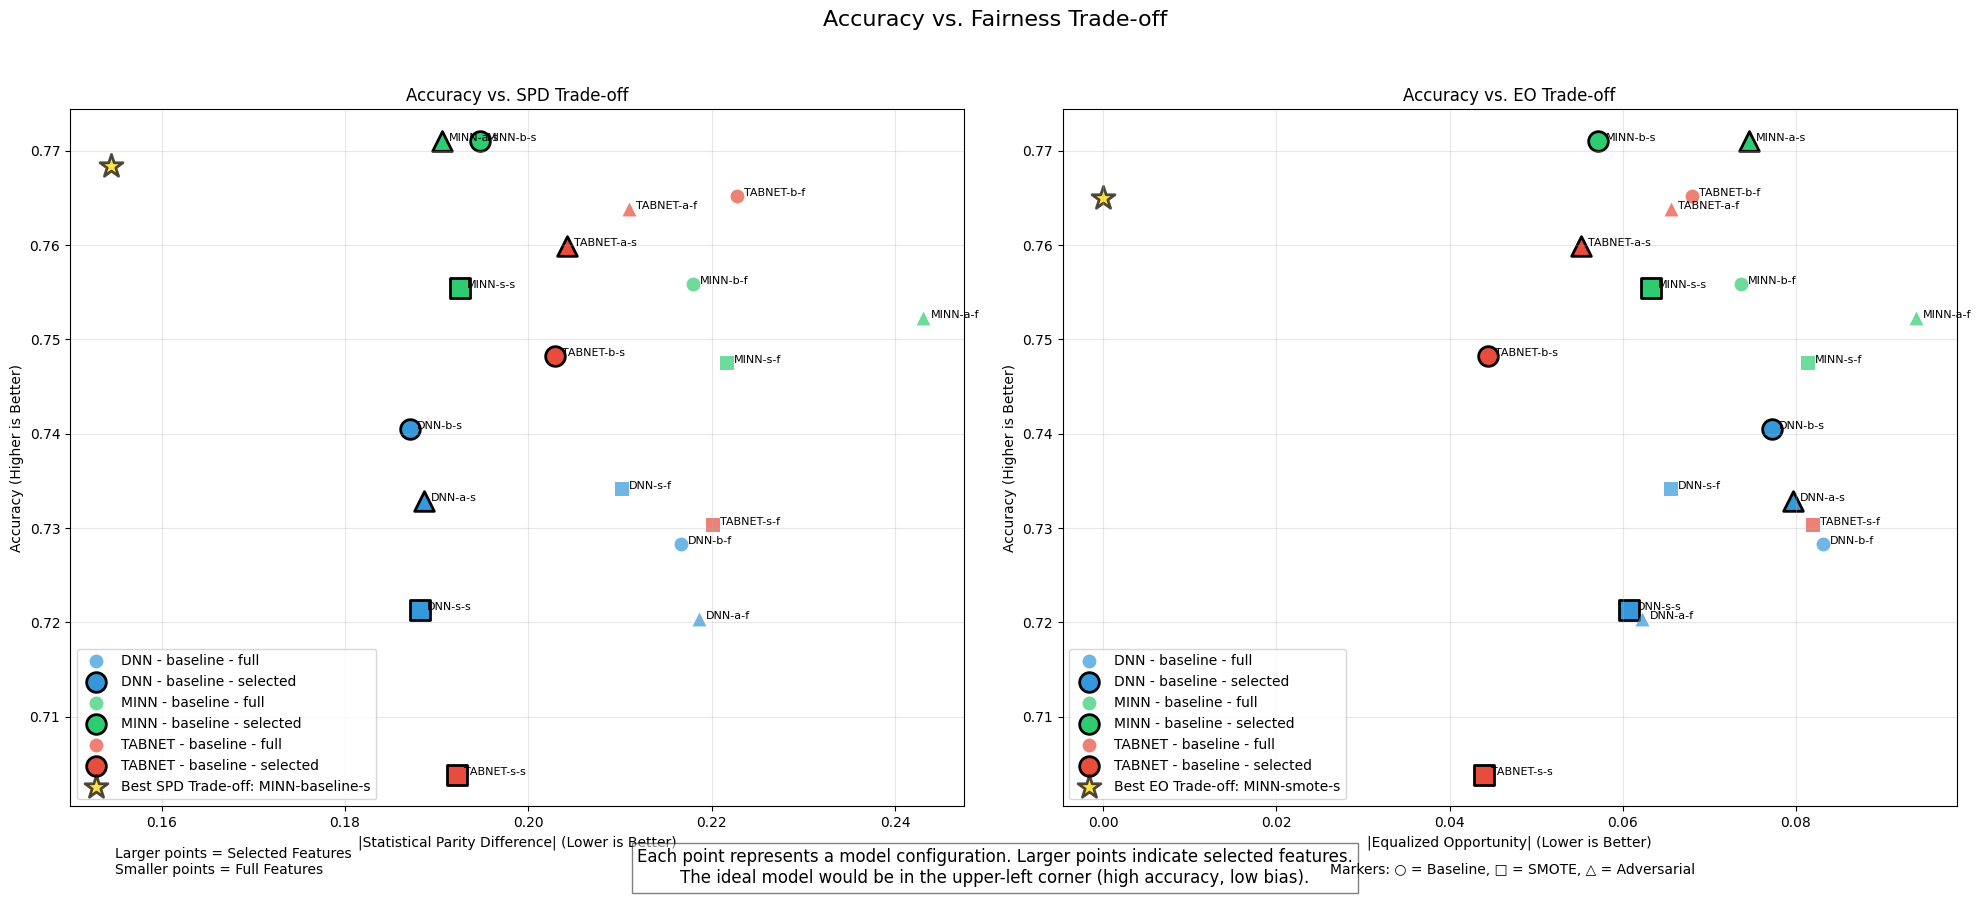

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create fairness-accuracy tradeoff visualization
plt.figure(figsize=(20, 10))

# Create subplots for SPD and EO trade-offs
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Accuracy vs. Fairness Trade-off', fontsize=16)

# Set up colors, markers, and sizes
models = ['dnn', 'minn', 'tabnet']
variants = ['baseline', 'smote', 'adversarial']
feature_sets = ['full', 'selected']
colors = {'dnn': '#3498db', 'minn': '#2ecc71', 'tabnet': '#e74c3c'}
markers = {'baseline': 'o', 'smote': 's', 'adversarial': '^'}
sizes = {'full': 100, 'selected': 200}
alphas = {'full': 0.7, 'selected': 1.0}

# Calculate absolute values of fairness metrics
results_df['SPD_abs'] = results_df['SPD'].abs()
results_df['EO_abs'] = results_df['EO'].abs()

# 1. Accuracy vs. SPD Trade-off
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_spd_abs = subset['SPD_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                axes[0].scatter(
                    mean_spd_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=colors[model], 
                    marker=markers[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                axes[0].annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_spd_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=8
                )

# 2. Accuracy vs. EO Trade-off
for model in models:
    for variant in variants:
        for feature_set in feature_sets:
            # Filter for this combination
            subset = results_df[(results_df['model'] == model) & 
                              (results_df['variant'] == variant) &
                              (results_df['feature_set'] == feature_set)]
            
            if not subset.empty:
                # Calculate means if there are multiple entries
                mean_accuracy = subset['accuracy'].mean()
                mean_eo_abs = subset['EO_abs'].mean()
                
                # Add scatter point
                label = f"{model.upper()} - {variant} - {feature_set}" if variant == 'baseline' else None
                axes[1].scatter(
                    mean_eo_abs, mean_accuracy, 
                    s=sizes[feature_set], 
                    color=colors[model], 
                    marker=markers[variant],
                    alpha=alphas[feature_set],
                    edgecolor='black' if feature_set == 'selected' else None,
                    linewidth=2 if feature_set == 'selected' else 0,
                    label=label
                )
                
                # Add text annotation for each point
                axes[1].annotate(
                    f"{model.upper()}-{variant[0]}-{feature_set[0]}", 
                    (mean_eo_abs, mean_accuracy), 
                    textcoords="offset points",
                    xytext=(5, 0), 
                    fontsize=8
                )

# Highlight the best models (upper-left corner is ideal)
# Find the model with best accuracy/fairness trade-off
best_tradeoff = results_df.copy()
best_tradeoff['spd_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['SPD_abs'] + 0.0001)
best_tradeoff['eo_tradeoff'] = best_tradeoff['accuracy'] / (best_tradeoff['EO_abs'] + 0.0001)

best_spd = best_tradeoff.loc[best_tradeoff['spd_tradeoff'].idxmax()]
best_eo = best_tradeoff.loc[best_tradeoff['eo_tradeoff'].idxmax()]

axes[0].scatter(
    best_spd['SPD_abs'], best_spd['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best SPD Trade-off: {best_spd['model'].upper()}-{best_spd['variant']}-{best_spd['feature_set'][0]}"
)

axes[1].scatter(
    best_eo['EO_abs'], best_eo['accuracy'], 
    s=300, color='gold', edgecolor='black', linewidth=2, alpha=0.7,
    marker='*', label=f"Best EO Trade-off: {best_eo['model'].upper()}-{best_eo['variant']}-{best_eo['feature_set'][0]}"
)

# Add formatting to the SPD plot
axes[0].set_xlabel('|Statistical Parity Difference| (Lower is Better)')
axes[0].set_ylabel('Accuracy (Higher is Better)')
axes[0].set_title('Accuracy vs. SPD Trade-off')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='lower left')

# Add formatting to the EO plot
axes[1].set_xlabel('|Equalized Opportunity| (Lower is Better)')
axes[1].set_ylabel('Accuracy (Higher is Better)')
axes[1].set_title('Accuracy vs. EO Trade-off')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='lower left')

# Add annotations
plt.figtext(0.5, 0.01, 
           'Each point represents a model configuration. Larger points indicate selected features.\n'
           'The ideal model would be in the upper-left corner (high accuracy, low bias).',
           ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Add mini-legend explaining point size and transparency
plt.figtext(0.06, 0.02, 
           'Larger points = Selected Features\nSmaller points = Full Features',
           ha='left', fontsize=10)

# Add mini-legend explaining markers
marker_legend = "Markers: ○ = Baseline, □ = SMOTE, △ = Adversarial"
plt.figtext(0.85, 0.02, 
           marker_legend,
           ha='right', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('accuracy_fairness_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

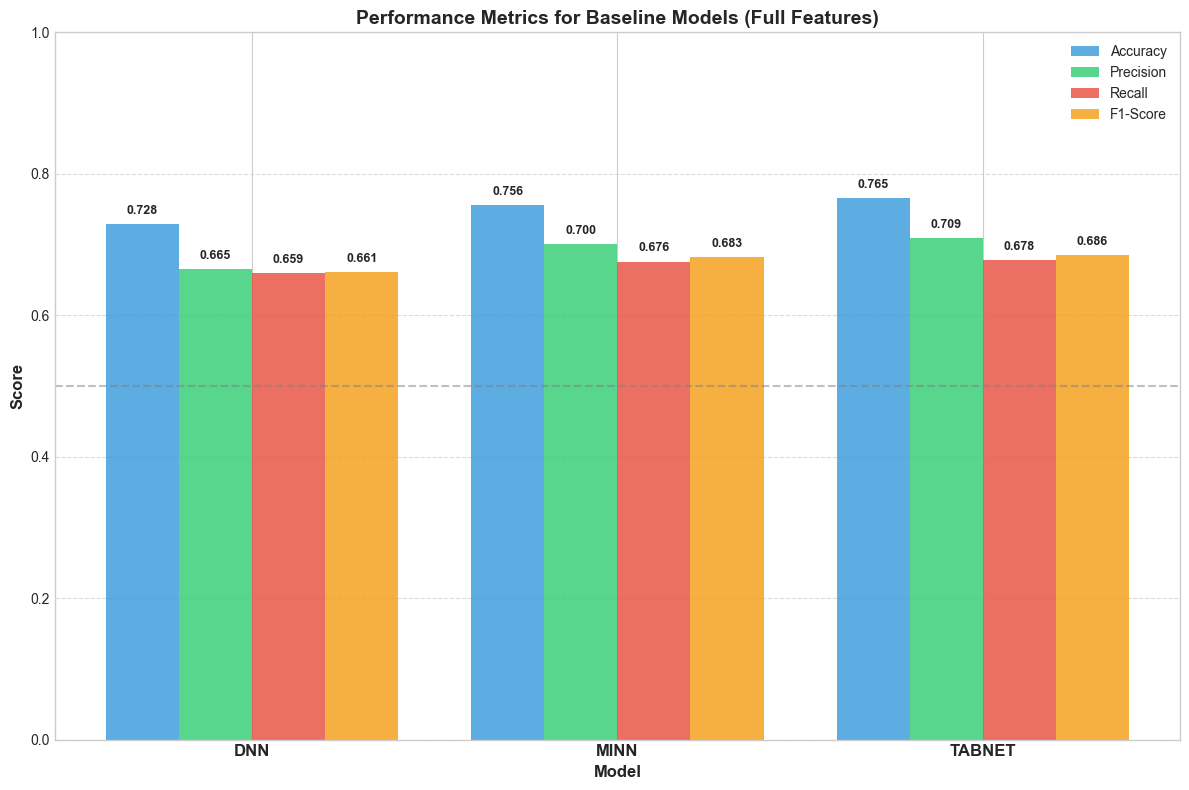

<Figure size 1200x800 with 0 Axes>

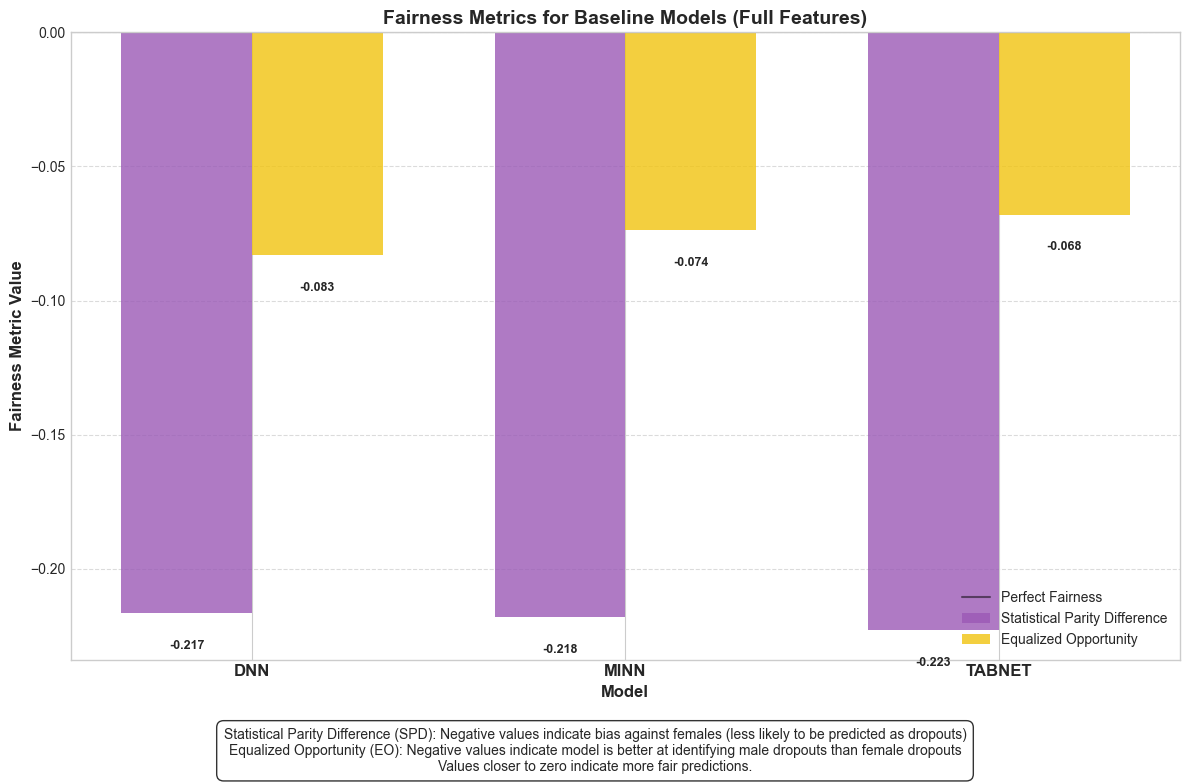

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming results_df is your results DataFrame
# First, filter for baseline models with full features
baseline_full = results_df[(results_df['variant'] == 'baseline') & 
                           (results_df['feature_set'] == 'full')]

# Set styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Create a figure for performance metrics
plt.figure(figsize=(12, 8))
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Define metrics and their labels
performance_metrics = ['accuracy', 'precision', 'recall', 'f1']
pretty_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Calculate means for each model and metric
model_means = baseline_full.groupby('model')[performance_metrics].mean()

# Define bar positions and width
bar_width = 0.2
x = np.arange(len(model_means.index))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']  # Blue, Green, Red, Orange

# Plot each performance metric as a group of bars
for i, metric in enumerate(performance_metrics):
    ax1.bar(x + (i - 1.5) * bar_width, model_means[metric], 
           width=bar_width, label=pretty_labels[i], color=colors[i], alpha=0.8)
    
    # Add value labels on top of bars
    for j, value in enumerate(model_means[metric]):
        ax1.text(x[j] + (i - 1.5) * bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add labels and title
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics for Baseline Models (Full Features)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([model.upper() for model in model_means.index], fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.0)  # Set y-axis limit from 0 to 1

# Add a grid for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at y=0.5 for reference
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()  # Display the plot instead of saving it

# Create a figure for fairness metrics
plt.figure(figsize=(12, 8))
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Define fairness metrics
fairness_metrics = ['SPD', 'EO']
pretty_fairness_labels = ['Statistical Parity Difference', 'Equalized Opportunity']

# Calculate means for each model and fairness metric
fairness_means = baseline_full.groupby('model')[fairness_metrics].mean()

# Calculate absolute means for the chart title
abs_fairness_means = baseline_full.groupby('model')[fairness_metrics].apply(lambda x: x.abs().mean())

# Plot fairness metrics as bars (using the raw values, not absolute values)
bar_width = 0.35
x = np.arange(len(fairness_means.index))

# Use distinct colors for fairness metrics
fairness_colors = ['#9b59b6', '#f1c40f']  # Purple, Yellow

# Plot each fairness metric
for i, metric in enumerate(fairness_metrics):
    bars = ax2.bar(x + (i - 0.5) * bar_width, fairness_means[metric], 
                  width=bar_width, label=pretty_fairness_labels[i], 
                  color=fairness_colors[i], alpha=0.8)
    
    # Add value labels on top/bottom of bars
    for j, bar in enumerate(bars):
        value = fairness_means[metric].iloc[j]
        # Position the text above or below the bar depending on value
        if value < 0:
            va = 'top'
            offset = -0.01
        else:
            va = 'bottom'
            offset = 0.01
            
        ax2.text(bar.get_x() + bar.get_width() / 2, value + offset, 
                f'{value:.3f}', ha='center', va=va, fontsize=9, fontweight='bold')

# Add a horizontal line at y=0 for perfect fairness
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect Fairness')

# Add labels and title
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fairness Metric Value', fontsize=12, fontweight='bold')
ax2.set_title('Fairness Metrics for Baseline Models (Full Features)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([model.upper() for model in fairness_means.index], fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)

# Add annotations explaining the fairness metrics
plt.figtext(0.5, 0.01, 
           'Statistical Parity Difference (SPD): Negative values indicate bias against females (less likely to be predicted as dropouts)\n'
           'Equalized Opportunity (EO): Negative values indicate model is better at identifying male dropouts than female dropouts\n'
           'Values closer to zero indicate more fair predictions.',
           ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Add a grid for better readability
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.08, 1, 0.98])  # Adjust to make room for the annotation
plt.show()  # Display the plot instead of saving it